# Assignment 3: Clustering California Housing with K-means

### CS 4774 Machine Learning - Department of Computer Science - University of Virginia
"Tonight, more than 130,000 Californians will go to sleep homeless. That’s enough to fill Dodger Stadium, AT&T Park and Petco Park. The biggest culprit is rising housing costs. From 2000 to 2014, median rent in California increased by more than one-third, while real incomes for renters fell by 7 percent. Today, 1.5 million Californians spend more than half their income on housing. This crisis threatens not just low-income families but our entire economy, driving businesses to relocate to states in which their employees can afford to live. - **Business Insider, Sep 2018.**"

![Half of the homes in San Franciso is now one million or above](https://amp.businessinsider.com/images/573de0b88d3eaea27198a55d-960-480.jpg)

In this assignment, you will attempt to cluster the California Housing by implementing and analyzing the k-means algorithm to the data. K-Means is one of the most popular clustering algorithms. K-means stores k-centroids that it uses to define clusters. A point is considered to be in a particular cluster if it is closer to that cluster's centroid than any other centroid. For references, you may refer to my lecture 9 or Chapter 2 of the textbook if you need additional sample codes to help with your assignment. For deliverables, you must write code in Python and submit this Jupyter Notebook file (.ipynb) to earn a total of 100 pts. You will gain points depending on how you perform in the following sections.

**Note**: In order for your assignment to be graded, you must save your Notebook filename under this format: **yourUvaUserId_assignment_3_kmeans.ipynb**.


---
## 1. PRE-PROCESSING THE DATA (10 pts)

Download the California Housing dataset from the below link. This dataset includes statistics about the median income, median age, average number of rooms per person, average number of persons in a household etc. The statistics were gathered per geographical block.

**Data Acquiring:** Download the dataset from https://www.kaggle.com/camnugent/california-housing-prices

**Data Discovery, Visualization, and Cleaning:** Fortunately, this step have been given to you from chapter 2. However, you should review them and write the code necessary for the purposes of this assignment. 

In [0]:
# You might want to use the following package
from pandas.plotting import scatter_matrix # optional
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import pandas as pd
# Your code goes here for this section.
housing = pd.read_csv('/housing.csv')


#####Data Discovery

In [0]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [0]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


#####Data Visualization

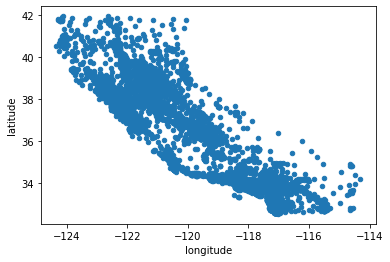

In [0]:
housing.plot(kind="scatter", x="longitude", y="latitude")

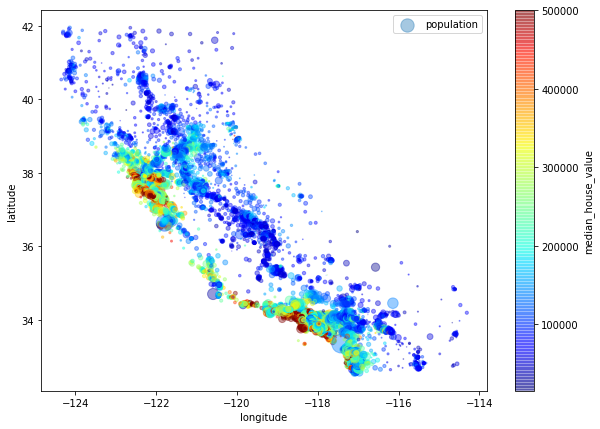

In [0]:
import matplotlib.pyplot as plt
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe62739c7f0>,
      dtype=object)

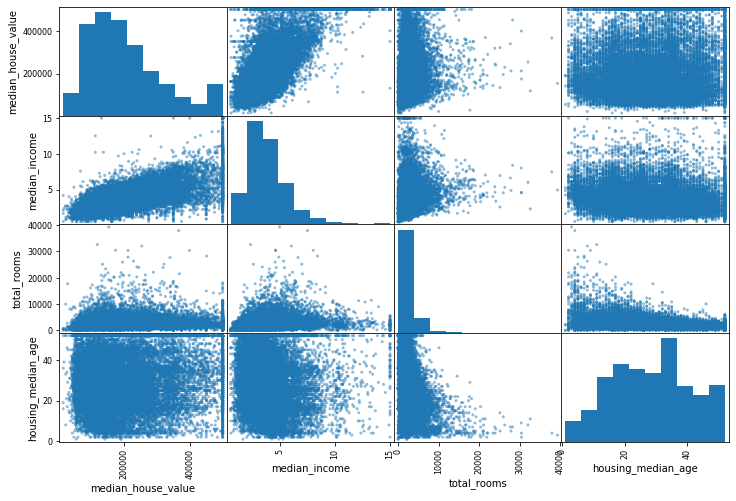

In [0]:
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

#####Data Cleaning

In [0]:
#Drop the object column because it causes difficulties in later step when unscaling centroid for graphs
housing_num = housing.drop("ocean_proximity",axis=1)
#fill none values with meadian
median = housing_num["total_bedrooms"].median()
housing_num["total_bedrooms"].fillna(median, inplace=True)
#standard scaler
std_scaler = StandardScaler()
housing_cleaned = std_scaler.fit_transform(housing_num)
housing_cleaned

array([[-1.32783522,  1.05254828,  0.98214266, ..., -0.97703285,
         2.34476576,  2.12963148],
       [-1.32284391,  1.04318455, -0.60701891, ...,  1.66996103,
         2.33223796,  1.31415614],
       [-1.33282653,  1.03850269,  1.85618152, ..., -0.84363692,
         1.7826994 ,  1.25869341],
       ...,
       [-0.8237132 ,  1.77823747, -0.92485123, ..., -0.17404163,
        -1.14259331, -0.99274649],
       [-0.87362627,  1.77823747, -0.84539315, ..., -0.39375258,
        -1.05458292, -1.05860847],
       [-0.83369581,  1.75014627, -1.00430931, ...,  0.07967221,
        -0.78012947, -1.01787803]])

- - -
## 2. IMPLEMENTING K-MEANS (40 pts)

You must implement your own version of K-Means Algorithm. Input a cluster count K and M data points each with its own vector of N features, along with the choice of a distance measure; then:

1. Initialize K centroids. In our case, a centroid is just the average of all data in a cluster.
2. Assign each data point to the cluster that has the closest centroid base on a **distance measure** below.
3. After all data points have been assigned to clusters, recalculate the centroids for each cluster (as averages of all points in the cluster).
4. Repeat the data assignments and centroid calculations until no change in housing assignment occurs between iterations.

**Distance Measures:** Your implementation must include three distance metrics: Manhattan Distance, Euclidean Distance, Sup Distance. These 3 distance metrics can be generalized by the Minkovski Distance:
$D(\mathbf{x},\mathbf{y}) = \sqrt[\leftroot{2}\uproot{2}p]{\sum\limits_{i=1}^n|x_i - y_i|^p}$ where $p=1$ for Mahattan, $p=2$ for Euclidean, and $p=\infty$ for Sup Distance.

**Implementation Notes:** Note that your functions should return distance measures; that is, the returned value should be high if the two vectors are dissimilar, low if they are similar, and zero if they are completely identical.

In [0]:
# Function: K Means
# -------------
# K-Means is an algorithm that takes in a dataset and a constant
# k and returns k centroids (which define clusters of data in the
# dataset which are similar to one another).
import numpy as np
import random
#Define three distance measurement outside the class
def distance_Manhattan(X, y):
    distance = 0
    for i in range(len(X)):
        disance = abs(X[i]-y[i]) + distance
    return distance
        
def distance_Euclidean(X, y):
    distance = np.linalg.norm(X-y)
    return distance

def distance_Sup(X, y):
    dis_max = 0
    for i in range(len(X)):
        distance = X[i]-y[i] 
        if(distance>dis_max):
            dis_max = distance
    return dis_max


class K_Means:
    def __init__(self, distance_measure):
      self.d = distance_measure


    def fit(self, X, k):
      centroids = []
      clusters = []
      num_col = X.shape[1]
      SSE = 0

      #First we initialize our centroids, in which we just pick up the first k rows from our data. 
      #It is fine because later we will adjust them ieratively.
      for i in range(k):
          centroids.append(X[i])

      #Then we do step 2, 3, 4 iteratively
      recalculate_indicator = 1
      itr = 0
      #stop the iteration if recalculator is unnecessary and iteration reaches max=100
      while(recalculate_indicator!=0 and itr < 100):
        recalculate_indicator = 0 #set it = 0, assuming no more iteration is needed
        itr +=1
        cluster_num = [] #We do not want to use dictionary, so we created another list to 
        #store the clutser number for each row in data
        for i in range(k):
          clusters.append([])
        #assign each data to corresponding clusters 
        for featureset in X:
          min_distance = 999999999
          min_index = 0
          for i in range(k):
            distance = self.d(featureset, centroids[i])
            if(distance < min_distance):
              min_distance = distance
              min_index = i
          clusters[min_index].append(featureset)
          SSE+=min_distance
          cluster_num.append(min_index)
        #This loop is used to check if recalculation is needed.
        for i in range(k):
          c = centroids[i]
          row_num = random.randint(0, X.shape[0])
          #It may happen that one cluster is empty, so we fill up the cluster with one random row from data
          #Otherwise I encountered invalid index error later
          if (clusters[i]==[]): 
            clusters[i].append(X[row_num])
          centroids[i] = np.mean(clusters[i],axis=0)
          if not np.array_equal(c,centroids[i]):
            recalculate_indicator = 1
      return centroids, clusters, cluster_num, SSE

- - -
## 3. CLUSTERING HOUSING INTO REGIONS (40 pts)

Now that you have implemented the K-Means as the clustering algorithm. Applying the algorithm for k=2 clusters to see if you can split California into a Northern and Southern regions.

* **Cluster the data:** Report the SSE (sum squared error), cluster means, within cluster standard deviations for each attribute, etc. Visualize the clustering by plot the latitude along the X axis and longitude along the Y axis. You should get a plot that looks roughly in the shape of California (see Chapter 2 for more details). Using the cluster means and std. deviations as representative values in the cluster, what can you say about the clusters that were found? How do they compare with what you know about cities and areas in California? What can you attribute the gaps to? It will definitely be helpful to have a map of California handy.

* **Change the number of clusters:** Change k from 2 to 10 and repeat the clustering process above. Record cluster means and standard deviations. When you change k, do any additional patterns emerge? If so, what are they? Applying the algorithm for 10 clusters to see if it clearly identified the silicon valley area as one cluster (where houses are relatively new and expensive, median income is high), the area of San Francisco as another etc. While SF and Silicon Valley may have a somewhat similar profile (at least, compared with mid CA), they were separated mainly due to the latitude/longtitue properties, that involve a dimension of geographical cohesiveness.


In [0]:
# Your code goes here
clf = K_Means(distance_Sup)
centroids, clusters, cluster_labels, SSE= clf.fit(housing_cleaned, k=2)


In [0]:
print("SSE: ",SSE)
print("Cluster 1 mean for each attribute: ", np.mean(clusters[0],axis=0))
print("Cluster 1 standard deviation for each attribute: ",np.std(clusters[0],axis=0))
print("Cluster 2 mean for each attribute: ", np.mean(clusters[1],axis=0))
print("Cluster 2 standard deviation for each attribute: ",np.std(clusters[1],axis=0))

SSE:  2512931.433777297
Cluster 1 mean for each attribute:  [-0.68612731  0.69740782  0.3040535  -0.24839651 -0.25739013 -0.31415334
 -0.26396197 -0.15824927  0.00647771]
Cluster 1 standard deviation for each attribute:  [0.81576637 0.87853398 1.06657754 0.50143609 0.52576524 0.48561425
 0.5406103  0.7784912  1.11482177]
Cluster 2 mean for each attribute:  [ 0.61247802 -0.62254767 -0.27141622  0.22173349  0.22976172  0.28043194
  0.23562814  0.14126271 -0.00578239]
Cluster 2 standard deviation for each attribute:  [0.70940107 0.61802109 0.84911087 1.25058675 1.23853686 1.23102019
 1.23046892 1.14427034 0.8849671 ]


No handles with labels found to put in legend.


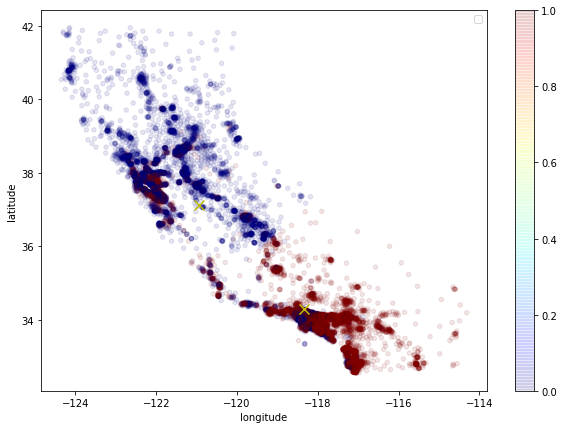

In [0]:
import matplotlib
import matplotlib.pyplot as plt

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1,
         figsize=(10,7), c=cluster_labels, cmap=plt.get_cmap("jet"),sharex=False)
#We have to unscale the centroid to plot correct longitude and latitude
centroids_inv = std_scaler.inverse_transform(centroids)
centroids_df = pd.DataFrame(data=centroids_inv,columns=list(housing_num))
plt.scatter(centroids_df['longitude'],centroids_df['latitude'], color = 'y', marker = "x", s = 100)
plt.legend()

Based on the scatter plot above, we can easily see that the housing in California was clustered mainly into north and south two parts. The means for cluster 1 and 2 are both small, which means that my implementation does a good job. In cluster 1, the attribute "population" has lowest stdev, and this means that the data in cluster 1 has about the same population. In cluster 2 the attribute "latitude" has the lowest stdev. As we can see from the plot, cluster 2 dots are more concentrated, resulting in the lower stdev for latitude. In terms of California map, cluster 2 contains many urban areas, including LA, SD, SF. 

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


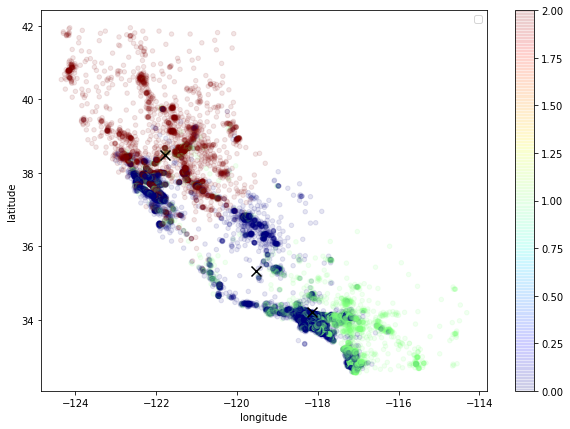

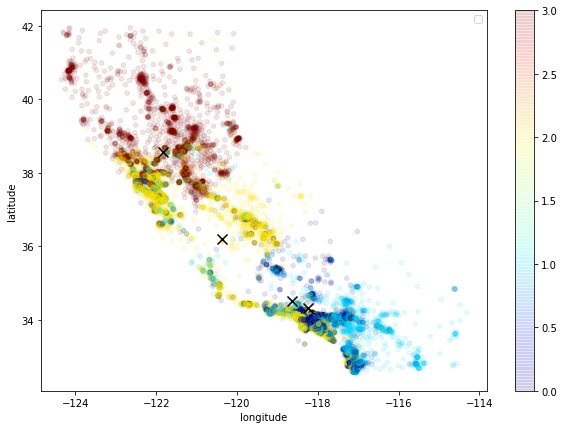

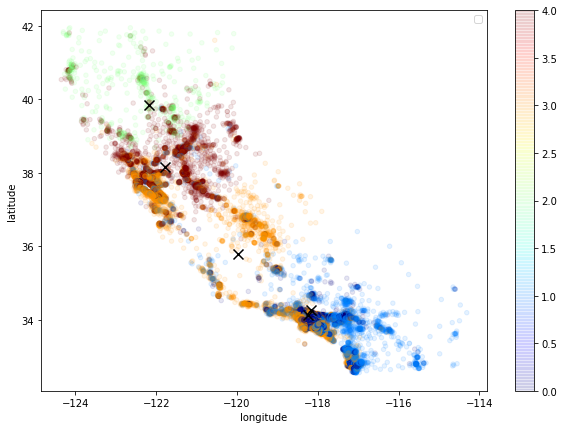

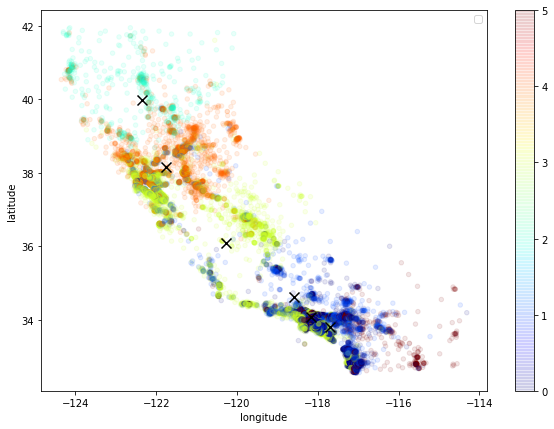

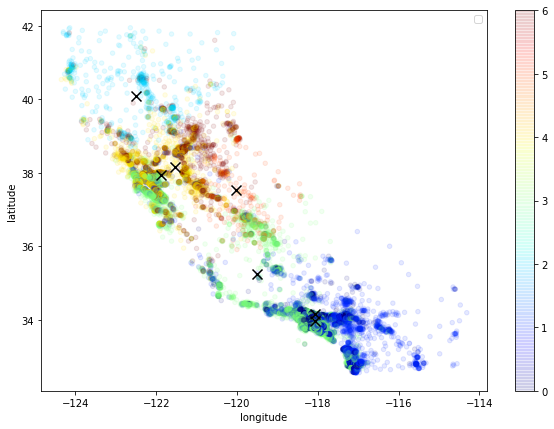

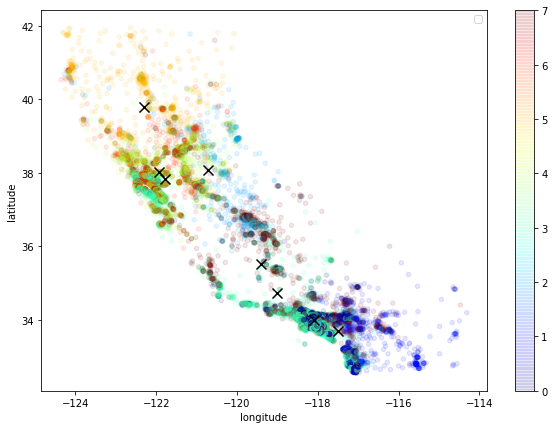

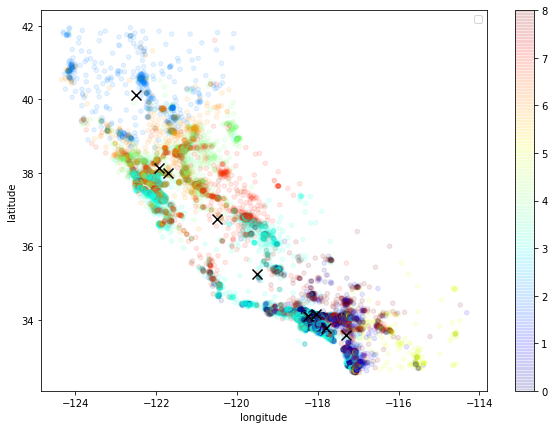

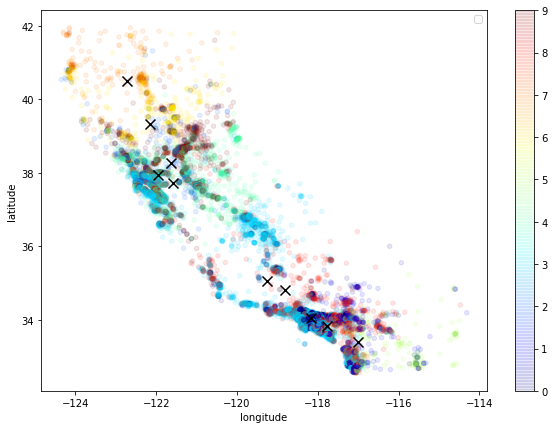

In [0]:
SSE_n =[[], [], [], [], [], [], [], []]
centroids_n =[[], [], [], [], [], [], [], []]
cluster_labels_n = [[], [], [], [], [], [], [], []]
clusters_n = [[], [], [], [], [], [], [], []]
for i in range(3,11):
  clf = K_Means(distance_Sup)
  centroids_n[i-3],clusters_n[i-3],cluster_labels_n[i-3],SSE_n[i-3] = clf.fit(housing_cleaned,i)

for i in range(3,11):
  housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1,
         figsize=(10,7),c=cluster_labels_n[i-3],cmap=plt.get_cmap("jet"),sharex=False)
  centroids_inv = std_scaler.inverse_transform(centroids_n[i-3])
  centroids_df = pd.DataFrame(data=centroids_inv,columns=list(housing_num))
  plt.scatter(centroids_df['longitude'],centroids_df['latitude'],color = 'k', marker = "x", s = 100)
  plt.legend()

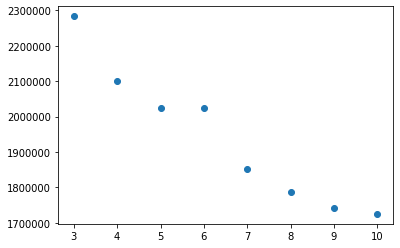

In [0]:
plt.scatter(list(range(3,11)),SSE_n)
plt.show()

As we increase the number of clusters, we can see some controids appear in some big cities which are close, like 
Scillicon Valley and San Fransco. As the same time, more patterns are indentified and clustered. However, some of them 
are excessive and did not provide much information. That's why we use Elbow Curve to get optimal number of cluster 

- - -
## 4. WRITING ON THE INTUITION FOR THE CALIFORNIA HOUSING CRISIS (10 pts)

This question is a qualitative one, and is intended to let you experiment with a real world clustering task. Hopefully it gives you some intuition as for how the preset number of clusters affects the clustering results. Too few clusters may not reveal the information that is in the data. Too many clusters may hurt data analysis as well, as it may not generalize (and in this sense, it is equivalent to over fitting).

Write at least one paragraph to demonstrate your intuition on the California Housing Crisis. You might also want to mention some possible solutions to solve it. You will receive credits based upon your insights and intuitions on this challenge. 



There is always a trade-off between number of clusters and the amount information that we want. 10 clutsers successfully group SF and SV into different clusters, but there are too many clusters that did not give much info. Based on the Elbow curve and graphs, I would suggest we use 5 clusters.

As for the California Housing Crisis, based on the clustering that we have, we always see some condensed dots around big cities. This conforms the observation from other resources. The state has four of the country’s five most expensive residential markets—Silicon Valley, San Francisco, Orange County and San Diego, and with LA as seventh. The condensed dots around urban areas imply that more people move to urban areas and leads to high demand. High demand around urban areas results in the high housing price with limited supplies. In order to solve this, government should encourage public to live in more sub-urban areas. This can be done by providing better public transportation and stipend, so people have more incentive to live out of big cities.

- - - 
### NEED HELP?

In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my lectures and/or the textbook
 * Talk to the TA, they are available and there to help you during their OH.
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS4774 Assignment 3:...".

Best of luck and have fun!